# DBScan

In [489]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [490]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

In [491]:
n_clusters = 6
n_samples = 250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [492]:
centroids = torch.rand(n_clusters, 2)*70-35

In [493]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [494]:
torch.diag(tensor([5.,5.]))

tensor([[5., 0.],
        [0., 5.]])

In [495]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [496]:
slices = [sample(c) for c in centroids]

In [497]:
def plot_data(data, ax=None):
    if ax is None: _,ax = plt.subplots()
    for group in data:
        ax.scatter(group[:,0], group[:,1], s=1)

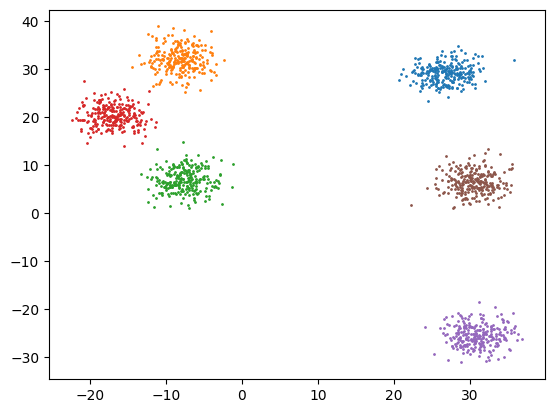

In [498]:
plot_data(slices)

In [499]:
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [500]:
data[:,0].shape # all xs, [:,1] all ys

torch.Size([1500])

In [501]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

## DBScan Definition

Consider a set of points in some space to be clustered. Let ε be a parameter specifying the radius of a neighborhood with respect to some point. For the purpose of DBSCAN clustering, the points are classified as core points, (directly-) reachable points and outliers, as follows:

- A point p is a core point if at least minPts points are within distance ε of it (including p).
- A point q is directly reachable from p if point q is within distance ε from core point p. Points are only said to be directly reachable from core points.
- A point q is reachable from p if there is a path p1, ..., pn with p1 = p and pn = q, where each pi+1 is directly reachable from pi. Note that this implies that the initial point and all points on the path must be core points, with the possible exception of q.
- All points not reachable from any other point are outliers or noise points.

Now if p is a core point, then it forms a cluster together with all points (core or non-core) that are reachable from it. Each cluster contains at least one core point; non-core points can be part of a cluster, but they form its "edge", since they cannot be used to reach more points. 

A cluster [then] satisfies two properties:

1. All points within the cluster are mutually density-connected.
2. If a point is density-reachable from some point of the cluster, it is part of the cluster as well.

The DBSCAN algorithm can be abstracted into the following steps:

1. Find the points in the ε (eps) neighborhood of every point, and identify the core points with more than minPts neighbors.
2. Find the connected components of core points on the neighbor graph, ignoring all non-core points.
3. Assign each non-core point to a nearby cluster if the cluster is an ε (eps) neighbor, otherwise assign it to noise.

https://en.wikipedia.org/wiki/DBSCAN#Abstract_algorithm

## Non-parallelized implementation

In [502]:
eps = 0.5 # max distance to be considered neighbours
min_pts = 5 # min points

In [503]:
X = data.clone()
x = data[:5]

In [504]:
data[0].shape

torch.Size([2])

In [505]:
def is_neighbour(point, other_points, eps):
    return (((point-other_points)**2).sum(dim=1) <= eps)

In [506]:
foo = {}
"bar" not in foo

True

In [507]:
for i in torch.nonzero(is_neighbour(x[0], X, eps)).squeeze():
    print(i, X[i])

tensor(0) tensor([26.204, 26.349])
tensor(72) tensor([25.807, 26.060])
tensor(151) tensor([26.459, 26.723])
tensor(182) tensor([26.446, 26.410])
tensor(194) tensor([26.814, 26.671])
tensor(208) tensor([26.085, 25.912])
tensor(215) tensor([26.843, 26.434])
tensor(221) tensor([25.865, 26.078])
tensor(233) tensor([26.895, 26.417])
tensor(239) tensor([25.534, 26.495])


In [508]:
torch.nonzero(is_neighbour(x[0], X, 0.5)).squeeze().tolist()

[0, 72, 151, 182, 194, 208, 215, 221, 233, 239]

In [509]:
def is_neighbour(point, other_points, eps):
    return (((point-other_points)**2).sum(dim=1) <= eps)

def build_groups(group_data, group_count, data_length):
    groups = []
    
    for i in range(1, group_count):
        group_indexes = list(filter(lambda key: group_data[key] == i, group_data.keys()))
        group = X[group_indexes]
        groups.append(group)

    noise_indexes = list(filter(lambda key: key not in group_data or group_data[key] == "noise", list(range(0, data_length)))) # only expecting "not in" scenario if called as callback

    if len(noise_indexes) > 0:
        noise = X[noise_indexes]
        groups.append(noise)

    return groups

def dbscan(data, eps=0.5, min_pts=5, callback=lambda point_to_group, group_count, data_length: None):
    n = len(data)
    X = data.clone()

    point_to_group = {}
    group_label = 0
    
    for i in range(0, n):
        if i in point_to_group:
            continue
        
        datum = X[i]

        is_core_point = is_neighbour(datum, X, eps).sum() - 1 >= min_pts # subtract one as datapoint itself will also register as neighbour but shouldn't be counted
        
        if not is_core_point:
            point_to_group[i] = "noise"
            continue

        group_label = group_label + 1
        
        point_to_group[i] = group_label

        neighbour_indexes = torch.nonzero(is_neighbour(datum, X, eps)).squeeze().tolist()

        for ni in neighbour_indexes:
            if ni in point_to_group and point_to_group[ni] == "noise":
                point_to_group[ni] = group_label

            if ni in point_to_group:
                continue

            point_to_group[ni] = group_label

            recursed_neighbour_indexes = torch.nonzero(is_neighbour(X[ni], X, eps)).squeeze().tolist()
            recursed_neighbour_indexes = list(set(recursed_neighbour_indexes).difference(set(neighbour_indexes)))

            neighbour_indexes.extend(recursed_neighbour_indexes)

        callback(point_to_group, group_label+1, n)

    return build_groups(point_to_group, group_label+1, n)

In [510]:
clusters = dbscan(X, eps=0.5, min_pts=5)
clusters[0][:5]

tensor([[26.204, 26.349],
        [25.807, 26.060],
        [26.459, 26.723],
        [26.446, 26.410],
        [26.814, 26.671]])

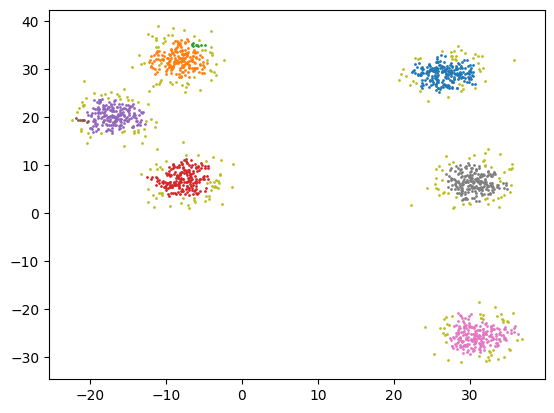

In [511]:
plot_data(clusters)

## Animation

In [512]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [513]:
intermediary_groups = []

def callback(group_data, group_count, data_length):
    intermediary_groups.append(build_groups(group_data, group_count, data_length))

dbscan(X, eps=0.5, min_pts=5, callback=callback)

final_group_len = len(intermediary_groups[-1])
group_count = len(intermediary_groups)

In [514]:
group_iterator = iter(intermediary_groups)

def plot_fn(d):
    ax.clear()
    
    next_data = next(group_iterator)
    group_len = len(next_data)

    noise_group = next_data.pop()

    next_data.extend([torch.empty(0, 2) for _ in range(final_group_len-group_len)]) # pad to keep group count and animation colours consistent
    
    next_data.append(noise_group)

    return plot_data(next_data, ax)

In [515]:
torch.empty(0, 2)

tensor([], size=(0, 2))

In [516]:
# create your own animation
fig,ax = plt.subplots()

ani = FuncAnimation(fig, plot_fn, frames=group_count-1, interval=1000, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## Modifying for GPU parallelizability

The three steps above do not lend themselves to a GPU-optimizable approach where point analysis is batched. An alternative approach could be as follows:

- Find all groups of points Gs such that each point within a group G is within ε (eps) of at least one other point in the group.
- Add all groups that do not contain a "core point" (as defined above) to "noise" group.
- Add all points that are not part of a group to "noise" group.

All remaining groups that are not the "noise" group would then be the clusters.

However, this approach implies analyzing all points at once rather than, e.g. 500 points at once. 

The above algorithm does not lend itself to a GPU-optimizable approach where point analysis is batched. To perform this iteratively, but analyzing more than one point at a time, we could proceed as follows:

- Find all core points one batch at a time.
- Compare and group core points in increments of batchsize

## Parallelized implementation

In [93]:
eps = 2 # max distance to be considered neighbours
min_pts = 5 # min points

In [94]:
X = data.clone()
x = data[:5]

In [95]:
X.shape, x.shape, x[:,None,:].shape, X[None].shape, (x[:,None,:]-X[None]).shape

(torch.Size([1500, 2]),
 torch.Size([5, 2]),
 torch.Size([5, 1, 2]),
 torch.Size([1, 1500, 2]),
 torch.Size([5, 1500, 2]))

In [96]:
(((x[:,None,:]-X[None])**2).sum(dim=2).sqrt() <= eps).sum(dim=1) > 5

tensor([True, True, True, True, True])

1. Find the points in the ε (eps) neighborhood of every point, and identify the core points with more than minPts neighbors.

In [97]:
def euclidean_distance(points, other_points):
    return torch.einsum('ijk,ijk->ij', points-other_points, points-other_points).sqrt()

In [98]:
def not_noise(batch, other_points, eps=2, min_neighbours=5):
    return (euclidean_distance(batch[:,None,:], other_points[None]) <= eps).sum(dim=1) >= min_neighbours

In [99]:
is_noise(x, X)

tensor([False, False, False, False, False])

In [100]:
s = slice(0, 500)

In [101]:
X[s].shape, X[s][not_noise(X[s], X)].shape

(torch.Size([500, 2]), torch.Size([483, 2]))

In [102]:
partial?

Init signature: partial(func, /, *args, **keywords)
Docstring:     
Create a new function with partial application of the given arguments
and keywords.
File:           /nix/store/iyff8129iampdw13nlfqalzhxy8y1hi9-python3-3.13.6/lib/python3.13/functools.py
Type:           type
Subclasses:     

2. Find the connected components of core points on the neighbor graph, ignoring all non-core points.

In [103]:
nn = partial(not_noise, other_points=X, eps=eps, min_neighbours=min_pts)
nn(x)

tensor([True, True, True, True, True])

In [86]:
def dbscan(data, bs=500, eps=2, min_pts=5):
    n = len(data)
    X = data.clone()
    for i in range(0, n, bs):
        s = slice(i, min(i+bs,n))
        batch = X[s]
        not_noise = partial(not_noise, other_points=X, eps=eps, min_neighbours=min_pts)
        core_points = batch[not_noise(batch)]
        weight = gaussian(dist_b(X, X[s]), 2.5)
#             weight = tri(dist_b(X, X[s]), 8)
        div = weight.sum(1, keepdim=True)
        X[s] = weight@X/div
    return X

In [29]:
dist = torch.einsum('ik,ik->i', x-X, x-X).sqrt()
dist[:8]

tensor([0.000, 2.813, 3.713, 6.068, 1.624, 1.011, 2.537, 3.492])

In [30]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.085,     0.053,  ...,     0.000,     0.000,     0.000])

In [31]:
weight.shape,X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [32]:
weight[:,None].shape

torch.Size([1500, 1])

In [33]:
weight[:,None]*X

tensor([[    4.397,     4.391],
        [    2.174,     2.507],
        [    1.286,     1.550],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [34]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
#         weight = gaussian(dist, 2.5)
        weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [35]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [36]:
%time X=meanshift(data)

CPU times: user 491 ms, sys: 0 ns, total: 491 ms
Wall time: 491 ms


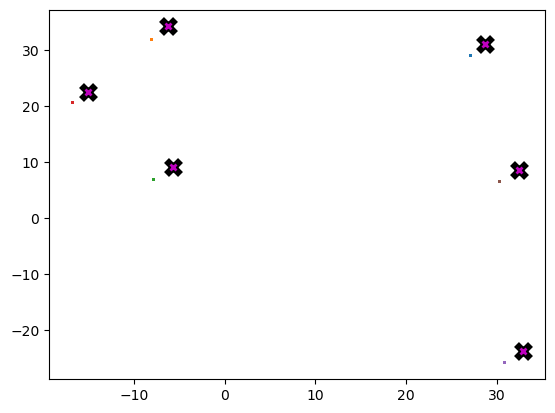

In [37]:
plot_data(centroids+2, X, n_samples)

## Animation

In [38]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [39]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [40]:
# create your own animation
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [41]:
bs=5
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [42]:
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()

In [43]:
dist_b(X, x)

tensor([[ 0.000,  2.813,  3.713,  ..., 17.468, 21.972, 19.654],
        [ 2.813,  0.000,  1.421,  ..., 20.034, 24.335, 22.111],
        [ 3.713,  1.421,  0.000,  ..., 20.239, 24.322, 22.194],
        [ 6.068,  4.204,  2.783,  ..., 20.885, 24.503, 22.583],
        [ 1.624,  1.483,  2.097,  ..., 18.554, 22.858, 20.629]])

In [44]:
dist_b(X, x).shape

torch.Size([5, 1500])

In [45]:
X[None,:].shape, x[:,None].shape, (X[None,:]-x[:,None]).shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]), torch.Size([5, 1500, 2]))

In [46]:
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[    0.199,     0.074,     0.036,  ...,     0.000,     0.000,     0.000],
        [    0.074,     0.199,     0.155,  ...,     0.000,     0.000,     0.000],
        [    0.036,     0.155,     0.199,  ...,     0.000,     0.000,     0.000],
        [    0.002,     0.022,     0.076,  ...,     0.000,     0.000,     0.000],
        [    0.143,     0.152,     0.115,  ...,     0.000,     0.000,     0.000]])

In [47]:
weight.shape,X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [48]:
weight[...,None].shape, X[None].shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [49]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [50]:
num

tensor([[548.960, 569.866],
        [555.972, 620.585],
        [405.019, 464.326],
        [117.351, 141.431],
        [569.842, 616.567]])

In [51]:
torch.einsum('ij,jk->ik', weight, X)

tensor([[548.960, 569.866],
        [555.972, 620.585],
        [405.019, 464.326],
        [117.351, 141.431],
        [569.842, 616.567]])

In [52]:
weight@X

tensor([[548.960, 569.866],
        [555.972, 620.585],
        [405.019, 464.326],
        [117.351, 141.431],
        [569.842, 616.567]])

In [53]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [54]:
num/div

tensor([[27.350, 28.392],
        [26.251, 29.302],
        [25.429, 29.153],
        [23.879, 28.779],
        [26.490, 28.662]])

In [55]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
#             weight = tri(dist_b(X, X[s]), 8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

In [56]:
slice?

Init signature: slice(self, /, *args, **kwargs)
Docstring:     
slice(stop)
slice(start, stop[, step])

Create a slice object.  This is used for extended slicing (e.g. a[0:10:2]).
Type:           type
Subclasses:     

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

In [57]:
data = data.cuda()

In [58]:
X = meanshift(data).cpu()

In [59]:
%timeit -n 5 _=meanshift(data, 1250).cpu()

1.92 ms ± 484 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


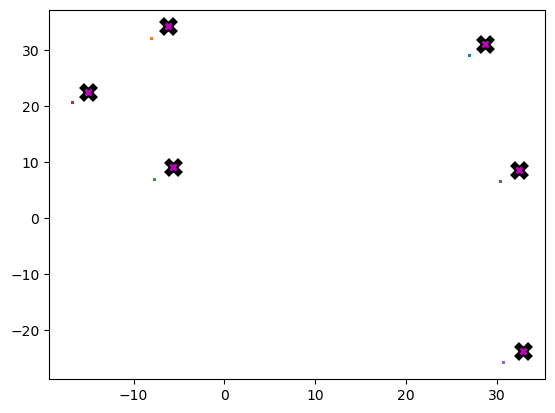

In [60]:
plot_data(centroids+2, X, n_samples)

**Homework:** implement k-means clustering, dbscan, locality sensitive hashing, or some other clustering, fast nearest neighbors, or similar algorithm of your choice, on the GPU. Check if your version is faster than a pure python or CPU version.

Bonus: Implement it in APL too!

Super bonus: Invent a new meanshift algorithm which picks only the closest points, to avoid quadratic time.

Super super bonus: Publish a paper that describes it :D